##### GLDADec (Our Proposed) deconvolution on GSE60424
- We downloaded the processed data from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE60424.
- 5 samples derived from human whole blood cells.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

BASE_DIR = '/workspace/github/GLDADec' # cloning repository
import sys
sys.path.append(BASE_DIR)

from run import pipeline

***
#### Load data

In [2]:
raw_df = pd.read_csv(BASE_DIR+'/data/GSE60424/GSE60424_expression.csv',index_col=0)
domain_dic = pd.read_pickle(BASE_DIR+'/data/marker/human_blood_domain.pkl')
random_sets = pd.read_pickle(BASE_DIR+'/data/random_info/100_random_sets.pkl')
target_facs = pd.read_csv(BASE_DIR+'/data/GSE60424/facs.csv',index_col=0)/100

***
#### Process marker information

In [3]:
# marker preprocessing for GSE60424
domain_dic = pd.read_pickle('/workspace/github/GLDADec/data/marker/domain_marker/results/v3/domain_dic.pkl')
# B cells
bcandi = []
bcandi.extend(domain_dic.get('B cells memory'))
bcandi.extend(domain_dic.get('B cells naive'))

# CD4 cells
cd4candi = []
cd4candi.extend(domain_dic.get('T cells CD4 memory'))
cd4candi.extend(domain_dic.get('T cells CD4 naive'))

# CD8 cels
cd8candi = domain_dic.get('T cells CD8')

# NK cells
nkcandi = domain_dic.get('NK cells')

# Lymphocyte
lymcandi = []
lymcandi.extend(bcandi)
lymcandi.extend(cd4candi)
lymcandi.extend(cd8candi)
lymcandi.extend(nkcandi)


# Monocytes
moncandi = domain_dic.get('Monocytes')

# Neutrophils
neucandi = domain_dic.get('Neutrophils')

# generate original marker dict
k = ['Lymphocytes','Monocytes','Neutrophils']
v = [lymcandi,moncandi,neucandi]
final_dic = dict(zip(k,v))

***
#### Conduct GLDADec
- We added 100 genes with large coefficients of variation between samples.
- The cell types to be evaluated are as follows:
    1. Lymphocytes
    2. Monocytes
    3. Neutrophils

  0%|          | 0/10 [00:00<?, ?it/s]

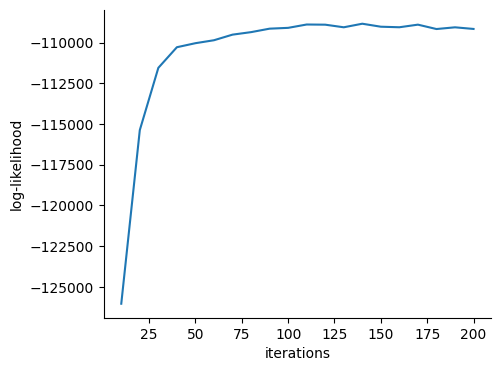

cells in res : ['Lymphocytes', 'Monocytes', 'Neutrophils']
cells in ref : ['Lymphocytes', 'Mon', 'Neu']


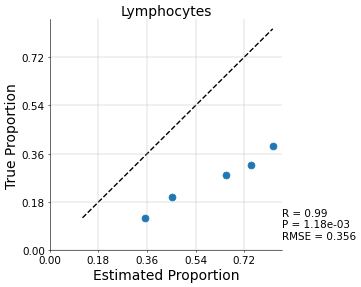

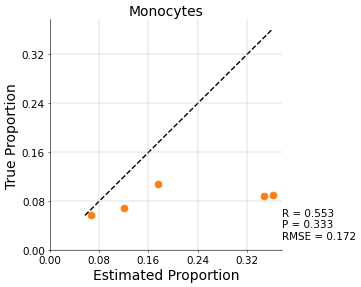

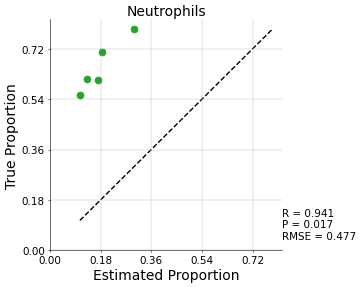

{'Lymphocytes': [('R', 0.9901), ('P', '1.18e-03'), ('RMSE', 0.3556)],
 'Monocytes': [('R', 0.5533), ('P', 0.333), ('RMSE', 0.1718)],
 'Neutrophils': [('R', 0.9413), ('P', 0.017), ('RMSE', 0.4772)]}


In [8]:
# single run and eval
# conduct deconv
pp = pipeline.Pipeline(verbose=False)
pp.from_predata(raw_df,target_samples=[],
                    do_ann=False,linear2log=False,log2linear=False,do_drop=True,do_batch_norm=False,do_quantile=False)
pp.gene_selection(method='CV',outlier=True,topn=100)
pp.add_marker_genes(target_cells=[],add_dic=final_dic)
pp.deocnv_prep(random_sets=random_sets,do_plot=False,specific=True,prior_norm=True,norm_scale=100,minmax=False,mm_scale=10)
pp.deconv(n=10,add_topic=0,n_iter=200,alpha=0.01,eta=0.01,refresh=10,initial_conf=1.0,seed_conf=1.0,other_conf=0.0,ll_plot=True,var_plot=False)

#%% evaluate
pp.evaluate(facs_df=target_facs,deconv_norm_range=['Lymphocytes','Monocytes','Neutrophils'],
                facs_norm_range=['Lymphocytes','Mon','Neu'],
                res_names=[['Lymphocytes'],['Monocytes'],['Neutrophils']],
                ref_names=[['Lymphocytes'],['Mon'],['Neu']],
                title_list = ['Lymphocytes','Monocytes','Neutrophils'],
                dpi=50,multi=False)

In [5]:
res = pp.merge_total_res[0]
display(res)

,Lymphocytes,Monocytes,Neutrophils
LIB222,0.746968,0.120149,0.132883
LIB272,0.449970,0.365947,0.184082
LIB341,0.826622,0.068065,0.105313
LIB259,0.352424,0.349572,0.298004
LIB315,0.650559,0.177525,0.171915
